# Homework 6

In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download using wget link mentioned below:

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [5]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(data, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
#Apply log transfor
df.median_house_value = np.log1p(df.median_house_value)

In [7]:
#Do train/validation/test split with 60%/20%/20% distribution

df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [11]:
#Use DictVectorizer to turn the dataframe into matrice

train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.


Which feature is used for splitting the data?

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
print(export_text(dt, feature_names= dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Question 2

Train a random forest model with these parameters:

    - n_estimators=10
    - random_state=1
    - n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [37]:
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred) 
np.sqrt(mse)

0.23149231798014028

Now let's experiment with the n_estimators parameter

    Try different values of this parameter from 10 to 200 with step 10.
    Set random_state to 1.
    Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

In [39]:
scores = []
for n in range(10,201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val,y_pred)
    
    scores.append((n, np.sqrt(mse)))

In [41]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104


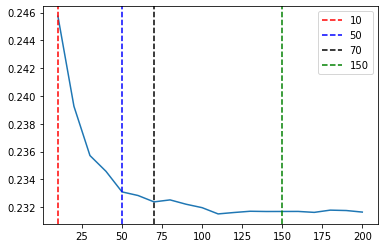

In [42]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.axvline(10, linestyle= '--', color='r', label=10)
plt.axvline(50, linestyle= '--', color='b', label=50)
plt.axvline(70, linestyle= '--', color='k', label=70)
plt.axvline(150, linestyle= '--', color='g', label=150)

plt.legend()

Question 4

Let's select the best max_depth:

    Try different values of max_depth: [10, 15, 20, 25]
    For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
    Fix the random seed: random_state=1

What's the best max_depth:

In [43]:
scores = []


for d in [10,15,20,25]:
    for n in range(10,201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val,y_pred)
        
        scores.append((d,n,np.sqrt(mse)))

In [47]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators','max_depth', 'rmse'])
df_scores.head()

,n_estimators,max_depth,rmse
0,10,10,0.255042
1,10,20,0.252784
2,10,30,0.251647
3,10,40,0.251062
4,10,50,0.250192


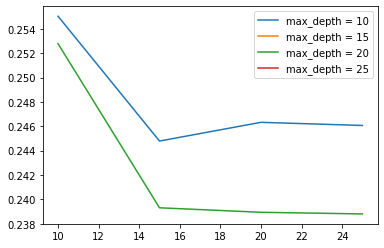

In [48]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label = 'max_depth = %d' % d)

plt.legend()

Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

    Train the model with these parametes:
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1 (optional)
    Get the feature importance information from this model

What's the most important feature?

In [49]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [57]:
idx_max = np.argmax(rf.feature_importances_)

In [58]:
dv.get_feature_names()[idx_max]

'median_income'

Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

    Install XGBoost
    Create DMatrix for train and validation
    Create a watchlist
    Train a model with these parameters for 100 rounds:


In [62]:
dtrain = xgb.DMatrix(X_train, label = y_train )
dval = xgb.DMatrix(X_val, label=y_val)

In [63]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
scores = {}

In [82]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
xgb.train(xgb_params, dtrain, num_boost_round = 100 , evals= watchlist )

In [71]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))


    columns = ['num_iter','train_rmse','val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [83]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

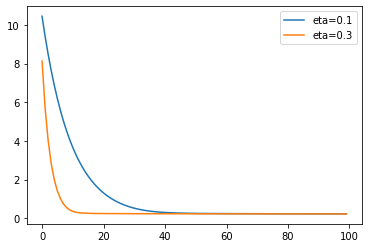

In [84]:
etas = ['eta=0.1', 'eta=0.3']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label = eta)

plt.legend()